In [1]:
import pybaseball as pyb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.utils import resample
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

In [2]:
mlb_21=pd.read_csv('mlb_21.csv').drop('Unnamed: 0', axis=1)
mlb_20=pd.read_csv('mlb_20.csv').drop('Unnamed: 0', axis=1)
mlb_19=pd.read_csv('mlb_19.csv').drop('Unnamed: 0', axis=1)

In [3]:
mlb_21['loc_x'] = (mlb_21['hc_x']-125.42)
mlb_21['loc_y'] = 198.27-mlb_21['hc_y']
mlb_21['phi'] = np.arctan(mlb_21['loc_x']/mlb_21['loc_y'])
mlb_21['spray_angle'] = mlb_21['phi']*(180/np.pi)*0.75
mlb_21['adj_angle'] = np.where(mlb_21['stand']=='R', mlb_21['spray_angle'], -1*mlb_21['spray_angle'])

In [4]:
out = ['field_out', 'grounded_into_double_play', 'force_out', 'field_error', 'double_play',
       'fielders_choice', 'fielders_choice_out', 'triple_play']
hit = ['single', 'double', 'home_run', 'triple']

In [5]:
hit_into_play = mlb_21[mlb_21['events'].isin(out)|mlb_21['events'].isin(hit)]
hit_into_play['hit'] = np.where(hit_into_play['events'].isin(hit), 1, 0)

In [6]:
hit_into_play[['launch_speed', 'launch_angle', 'spray_angle']] = round(hit_into_play[['launch_speed', 'launch_angle', 'spray_angle']],1)

<AxesSubplot:xlabel='loc_x', ylabel='loc_y'>

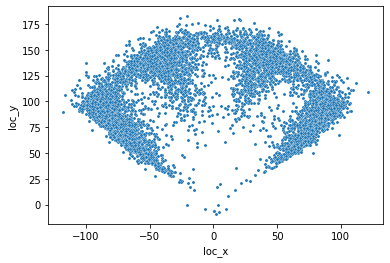

In [7]:
sns.scatterplot(data=hit_into_play[hit_into_play['events']=='double'], x='loc_x', y='loc_y', s=10)

In [8]:
df = hit_into_play[['stand', 'launch_speed', 'launch_angle', 'spray_angle', 'hit']]

In [9]:
df

,stand,launch_speed,launch_angle,spray_angle,hit
0,R,95.2,-13.0,-36.1,0
4,L,93.3,-18.0,15.2,0
9,R,75.3,65.0,45.7,0
18,L,96.8,18.0,15.3,0
27,R,91.8,29.0,20.3,0
...,...,...,...,...,...
709825,L,80.3,-40.0,8.9,0
709828,L,71.1,-37.0,36.6,0
709840,R,38.8,28.0,-37.6,0
709844,L,96.3,8.0,-28.7,1


In [10]:
df_clean = df.dropna()

In [11]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119344 entries, 0 to 709845
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   stand         119344 non-null  object 
 1   launch_speed  119344 non-null  float64
 2   launch_angle  119344 non-null  float64
 3   spray_angle   119344 non-null  float64
 4   hit           119344 non-null  int32  
dtypes: float64(3), int32(1), object(1)
memory usage: 5.0+ MB


In [12]:
df_clean

,stand,launch_speed,launch_angle,spray_angle,hit
0,R,95.2,-13.0,-36.1,0
4,L,93.3,-18.0,15.2,0
9,R,75.3,65.0,45.7,0
18,L,96.8,18.0,15.3,0
27,R,91.8,29.0,20.3,0
...,...,...,...,...,...
709825,L,80.3,-40.0,8.9,0
709828,L,71.1,-37.0,36.6,0
709840,R,38.8,28.0,-37.6,0
709844,L,96.3,8.0,-28.7,1


In [13]:
r_hit = df_clean[(df_clean['stand']=='R')&(df_clean['hit']==1)]
r_nohit = df_clean[(df_clean['stand']=='R')&(df_clean['hit']==0)]
l_hit = df_clean[(df_clean['stand']=='L')&(df_clean['hit']==1)]
l_nohit = df_clean[(df_clean['stand']=='L')&(df_clean['hit']==0)]

In [14]:
r_hit_downsampled = resample(r_hit, replace=False, n_samples=2000, random_state=42)
r_nohit_downsampled = resample(r_nohit, replace=False, n_samples=2000, random_state=42)
l_hit_downsampled = resample(l_hit, replace=False, n_samples=2000, random_state=42)
l_nohit_downsampled = resample(l_nohit, replace=False, n_samples=2000, random_state=42)

In [15]:
sample_data = pd.concat([r_hit_downsampled, r_nohit_downsampled, l_hit_downsampled, l_nohit_downsampled])

In [16]:
X = sample_data.drop('hit', axis=1).copy()
y = sample_data['hit'].copy()

In [17]:
X_encoded = pd.get_dummies(X, columns=['stand'])

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state=42)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [19]:
y_train

390308    0
448696    0
641401    1
423312    1
383401    0
         ..
461399    1
569764    1
502802    1
195473    0
118208    0
Name: hit, Length: 6000, dtype: int32

In [20]:
clf_svm = SVC(random_state=42)
clf_svm.fit(X_train_scaled, y_train)

SVC(random_state=42)

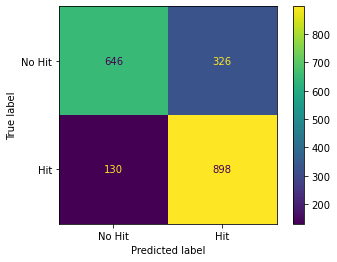

In [21]:
plot_confusion_matrix(clf_svm, 
                      X_test_scaled, 
                      y_test,
                      values_format='d',
                      display_labels=["No Hit", "Hit"])

In [22]:
param_grid = [
  {'C': [0.5, 1, 10, 100],
   'gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001], 
   'kernel': ['rbf']},
]

optimal_params = GridSearchCV(
        SVC(), 
        param_grid,
        cv=5,
        scoring='accuracy',
        verbose=0
    )

optimal_params.fit(X_train_scaled, y_train)
print(optimal_params.best_params_)

{'C': 10, 'gamma': 1, 'kernel': 'rbf'}


In [23]:
clf_svm = SVC(random_state=42, C=10, gamma=1, probability=True)
clf_svm.fit(X_train_scaled, y_train)

SVC(C=10, gamma=1, probability=True, random_state=42)

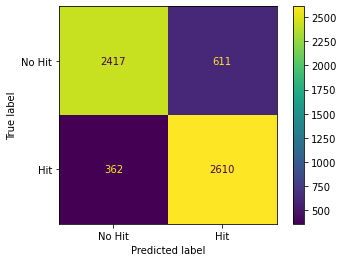

In [52]:
plot_confusion_matrix(clf_svm, 
                      X_train_scaled, 
                      y_train,
                      values_format='d',
                      display_labels=["No Hit", "Hit"])

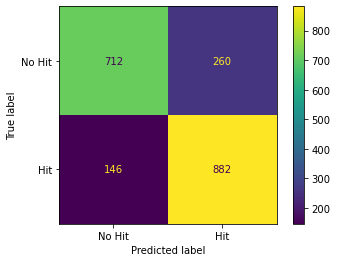

In [24]:
plot_confusion_matrix(clf_svm, 
                      X_test_scaled, 
                      y_test,
                      values_format='d',
                      display_labels=["No Hit", "Hit"])

In [25]:
clf_svm.score(X_train_scaled, y_train)

0.8378333333333333

In [26]:
clf_svm.score(X_test_scaled, y_test)

0.797

In [27]:
df_x = df_clean[['stand', 'launch_speed', 'launch_angle', 'spray_angle']]
df_dummy = pd.get_dummies(df_x, columns=['stand'])
df_scaled = scaler.transform(df_dummy)

In [28]:
clf_svm.predict_proba(df_scaled)

array([[0.79839289, 0.20160711],
       [0.86757829, 0.13242171],
       [0.96285875, 0.03714125],
       ...,
       [0.85787411, 0.14212589],
       [0.18032082, 0.81967918],
       [0.03152956, 0.96847044]])

In [29]:
df_clean['hit_prob'] = clf_svm.predict_proba(df_scaled)[:, 1]

In [30]:
df_clean

,stand,launch_speed,launch_angle,spray_angle,hit,hit_prob
0,R,95.2,-13.0,-36.1,0,0.201607
4,L,93.3,-18.0,15.2,0,0.132422
9,R,75.3,65.0,45.7,0,0.037141
18,L,96.8,18.0,15.3,0,0.795569
27,R,91.8,29.0,20.3,0,0.021252
...,...,...,...,...,...,...
709825,L,80.3,-40.0,8.9,0,0.159343
709828,L,71.1,-37.0,36.6,0,0.060952
709840,R,38.8,28.0,-37.6,0,0.142126
709844,L,96.3,8.0,-28.7,1,0.819679


In [53]:
df_clean[df_clean['hit']==0]

,stand,launch_speed,launch_angle,spray_angle,hit,hit_prob
0,R,95.2,-13.0,-36.1,0,0.201607
4,L,93.3,-18.0,15.2,0,0.132422
9,R,75.3,65.0,45.7,0,0.037141
18,L,96.8,18.0,15.3,0,0.795569
27,R,91.8,29.0,20.3,0,0.021252
...,...,...,...,...,...,...
709812,L,105.5,-7.0,-25.9,0,0.766918
709824,R,102.6,-1.0,-34.4,0,0.701325
709825,L,80.3,-40.0,8.9,0,0.159343
709828,L,71.1,-37.0,36.6,0,0.060952


In [31]:
df_clean[df_clean['hit_prob']<=0.5]

,stand,launch_speed,launch_angle,spray_angle,hit,hit_prob
0,R,95.2,-13.0,-36.1,0,0.201607
4,L,93.3,-18.0,15.2,0,0.132422
9,R,75.3,65.0,45.7,0,0.037141
27,R,91.8,29.0,20.3,0,0.021252
28,L,76.1,-25.0,36.0,0,0.107175
...,...,...,...,...,...,...
709804,L,97.7,-12.0,-1.3,1,0.282952
709814,R,73.6,2.0,-22.0,1,0.064820
709825,L,80.3,-40.0,8.9,0,0.159343
709828,L,71.1,-37.0,36.6,0,0.060952


In [32]:
df_clean[(df_clean['hit_prob']<=0.5)&(df_clean['hit']==0)]

,stand,launch_speed,launch_angle,spray_angle,hit,hit_prob
0,R,95.2,-13.0,-36.1,0,0.201607
4,L,93.3,-18.0,15.2,0,0.132422
9,R,75.3,65.0,45.7,0,0.037141
27,R,91.8,29.0,20.3,0,0.021252
28,L,76.1,-25.0,36.0,0,0.107175
...,...,...,...,...,...,...
709795,R,65.6,-39.0,-15.6,0,0.145761
709799,L,86.5,28.0,-19.2,0,0.022268
709825,L,80.3,-40.0,8.9,0,0.159343
709828,L,71.1,-37.0,36.6,0,0.060952


In [34]:
df_clean[(df_clean['hit_prob']>=0.5)&(df_clean['hit']==1)]

,stand,launch_speed,launch_angle,spray_angle,hit,hit_prob
44,L,94.4,15.0,-11.7,1,0.793717
111,R,90.4,16.0,-4.6,1,0.782166
137,R,68.8,22.0,22.4,1,0.915144
138,R,110.5,14.0,-29.0,1,0.828060
145,L,83.5,25.0,27.3,1,0.732600
...,...,...,...,...,...,...
709754,R,84.8,9.0,-10.9,1,0.708687
709787,R,102.2,0.0,17.4,1,0.790725
709820,R,103.2,8.0,-9.2,1,0.828127
709844,L,96.3,8.0,-28.7,1,0.819679


In [35]:
df_clean

,stand,launch_speed,launch_angle,spray_angle,hit,hit_prob
0,R,95.2,-13.0,-36.1,0,0.201607
4,L,93.3,-18.0,15.2,0,0.132422
9,R,75.3,65.0,45.7,0,0.037141
18,L,96.8,18.0,15.3,0,0.795569
27,R,91.8,29.0,20.3,0,0.021252
...,...,...,...,...,...,...
709825,L,80.3,-40.0,8.9,0,0.159343
709828,L,71.1,-37.0,36.6,0,0.060952
709840,R,38.8,28.0,-37.6,0,0.142126
709844,L,96.3,8.0,-28.7,1,0.819679


In [36]:
xba=pd.merge(hit_into_play, df_clean, on=['stand', 'launch_speed', 'launch_angle', 'spray_angle', 'hit'])

In [37]:
xba.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,fielder_2,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,loc_x,loc_y,phi,spray_angle,adj_angle,hit,hit_prob
0,FF,2021-10-03,92.3,1.40,6.80,"Smith, Will",596019,519293,field_out,hit_into_play,NaN,NaN,NaN,NaN,1.0,"Francisco Lindor grounds out, third baseman Eh...",R,R,L,ATL,NYM,X,5.0,ground_ball,1,2,2021,0.69,1.38,-0.69,2.83,NaN,NaN,NaN,2,9,Top,77.54,155.31,NaN,NaN,518595,NaN,NaN,-6.833043,-134.166485,-7.361843,9.708393,26.562803,-14.083224,3.32,1.51,13.0,95.2,-13.0,92.8,2330.0,6.5,632254,519293,518595,663586,645277,501303,606115,592696,628338,594807,54.03,0.174,0.158,0.0,1.0,0.0,0.0,2.0,61,4,4-Seam Fastball,5,0,0,5,0,5,0,5,Infield shift,Strategic,148.0,0.000,-0.073,-47.88,42.96,-0.839506,-36.1,-36.075133,0,0.201607
1,FF,2021-10-03,91.2,1.49,6.66,"Smith, Will",607043,519293,field_out,hit_into_play,NaN,NaN,NaN,NaN,4.0,"Brandon Nimmo grounds out, second baseman Ozzi...",R,L,L,ATL,NYM,X,4.0,ground_ball,1,0,2021,0.63,1.28,-0.31,2.80,NaN,NaN,NaN,1,9,Top,144.83,145.72,NaN,NaN,518595,NaN,NaN,-5.868477,-132.500539,-6.486796,8.700586,30.117690,-15.941174,3.49,1.60,9.0,93.3,-18.0,90.9,2281.0,6.3,632254,519293,518595,663586,645277,501303,606115,592696,628338,594807,54.15,0.100,0.090,0.0,1.0,0.0,0.0,2.0,60,2,4-Seam Fastball,5,0,0,5,0,5,0,5,Standard,Standard,143.0,0.002,-0.189,19.41,52.55,0.353819,15.2,-15.204255,0,0.132422
2,SI,2021-10-03,94.3,-1.20,6.05,"Gsellman, Robert",594807,607229,field_out,hit_into_play,NaN,NaN,NaN,NaN,8.0,Adam Duvall pops out to first baseman Pete Alo...,R,R,R,ATL,NYM,X,3.0,popup,0,2,2021,-1.35,0.88,-0.26,1.78,NaN,NaN,NaN,2,8,Bot,168.84,174.09,NaN,NaN,664850,NaN,NaN,5.470673,-137.010597,-7.331898,-18.151571,31.755423,-19.628348,3.41,1.56,140.0,75.3,65.0,94.4,1982.0,6.5,632254,607229,664850,624413,606299,542340,596019,642086,607043,624424,53.98,0.000,0.000,0.0,1.0,0.0,0.0,3.0,58,3,Sinker,5,0,5,0,0,5,5,0,Infield shift,Standard,221.0,0.000,-0.061,43.42,24.18,1.062682,45.7,45.665376,0,0.037141
3,SL,2021-10-03,90.5,-1.51,5.93,"Gsellman, Robert",645277,607229,field_out,hit_into_play,NaN,NaN,NaN,NaN,5.0,Ozzie Albies lines out to right fielder Michae...,R,L,R,ATL,NYM,X,9.0,line_drive,1,2,2021,0.01,0.62,0.01,2.23,NaN,NaN,NaN,0,8,Bot,166.52,88.11,NaN,NaN,664850,NaN,NaN,3.779828,-131.908322,-4.714347,-0.573116,24.210223,-24.134749,3.26,1.48,294.0,96.8,18.0,91.1,2133.0,6.3,632254,607229,664850,624413,606299,542340,596019,642086,607043,624424,54.23,0.409,0.457,0.0,1.0,0.0,0.0,4.0,56,4,Slider,5,0,5,0,0,5,5,0,Infield shift,Standard,216.0,-0.001,-0.173,41.10,110.16,0.357098,15.3,-15.345170,0,0.795569
4,FF,2021-10-03,94.9,-2.71,6.38,"Martin, Chris",606299,455119,field_out,hit_into_play,NaN,NaN,NaN,NaN,8.0,Jose Peraza flies out to right fielder Jorge S...,R,R,R,ATL,NYM,X,9.0,fly_ball,0,0,2021,-0.75,1.18,-0.10,1.94,NaN,NaN,NaN,1,8,Top,181.75,87.93,NaN,NaN,518595,NaN,NaN,8.562207,-137.797602,-8.629003,-11.450328,29.298997,-15.415123,3.37,1.53,308.0,91.8,29.0,95.5,2224.0,6.6,632254,455119,518595,663586,645277,501303,606115,592696,594807,624585,53.86,0.109,0.156,0.0,1.0,0.0,0.0

<AxesSubplot:xlabel='hit_prob', ylabel='Density'>

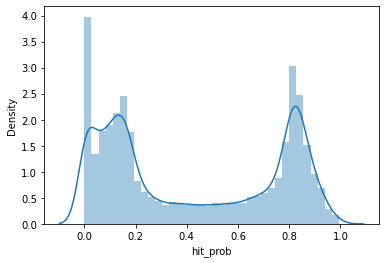

In [38]:
sns.distplot(xba['hit_prob'])

Text(0.5, 1.0, 'xBA of True Hit')

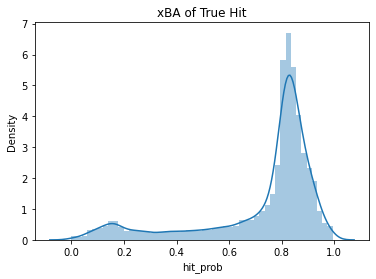

In [39]:
sns.distplot(xba[xba['hit']==1]['hit_prob'])
plt.title('xBA of True Hit')

Text(0.5, 1.0, 'Statcast xBA of True Hit')

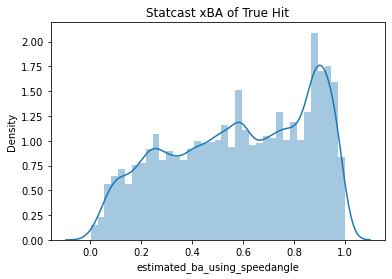

In [40]:
sns.distplot(xba[xba['hit']==1]['estimated_ba_using_speedangle'])
plt.title('Statcast xBA of True Hit')

Text(0.5, 1.0, 'xBA of True No Hit')

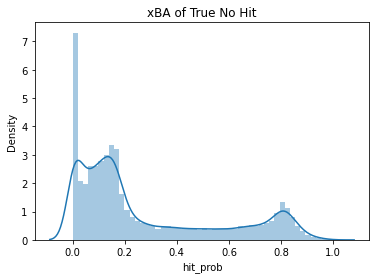

In [41]:
sns.distplot(xba[xba['hit']==0]['hit_prob'])
plt.title('xBA of True No Hit')

Text(0.5, 1.0, 'Statcast xBA of True No Hit')

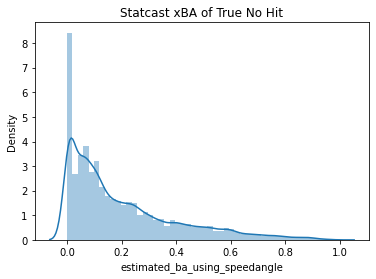

In [42]:
sns.distplot(xba[xba['hit']==0]['estimated_ba_using_speedangle'])
plt.title('Statcast xBA of True No Hit')

In [43]:
hit_into_play['spray_angle'] = round(hit_into_play['spray_angle'],1)
xba = pd.merge(hit_into_play, df_clean.drop('hit', axis=1), on=['stand', 'launch_speed', 'launch_angle', 'spray_angle'], how='left')

In [44]:
xba['count'] = xba['balls'].astype('str')+'-'+xba['strikes'].astype('str')
xba.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,fielder_2,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,loc_x,loc_y,phi,spray_angle,adj_angle,hit,hit_prob,count
0,FF,2021-10-03,92.3,1.40,6.80,"Smith, Will",596019,519293,field_out,hit_into_play,NaN,NaN,NaN,NaN,1.0,"Francisco Lindor grounds out, third baseman Eh...",R,R,L,ATL,NYM,X,5.0,ground_ball,1,2,2021,0.69,1.38,-0.69,2.83,NaN,NaN,NaN,2,9,Top,77.54,155.31,NaN,NaN,518595,NaN,NaN,-6.833043,-134.166485,-7.361843,9.708393,26.562803,-14.083224,3.32,1.51,13.0,95.2,-13.0,92.8,2330.0,6.5,632254,519293,518595,663586,645277,501303,606115,592696,628338,594807,54.03,0.174,0.158,0.0,1.0,0.0,0.0,2.0,61,4,4-Seam Fastball,5,0,0,5,0,5,0,5,Infield shift,Strategic,148.0,0.000,-0.073,-47.88,42.96,-0.839506,-36.1,-36.075133,0,0.201607,1-2
1,FF,2021-10-03,91.2,1.49,6.66,"Smith, Will",607043,519293,field_out,hit_into_play,NaN,NaN,NaN,NaN,4.0,"Brandon Nimmo grounds out, second baseman Ozzi...",R,L,L,ATL,NYM,X,4.0,ground_ball,1,0,2021,0.63,1.28,-0.31,2.80,NaN,NaN,NaN,1,9,Top,144.83,145.72,NaN,NaN,518595,NaN,NaN,-5.868477,-132.500539,-6.486796,8.700586,30.117690,-15.941174,3.49,1.60,9.0,93.3,-18.0,90.9,2281.0,6.3,632254,519293,518595,663586,645277,501303,606115,592696,628338,594807,54.15,0.100,0.090,0.0,1.0,0.0,0.0,2.0,60,2,4-Seam Fastball,5,0,0,5,0,5,0,5,Standard,Standard,143.0,0.002,-0.189,19.41,52.55,0.353819,15.2,-15.204255,0,0.132422,1-0
2,SI,2021-10-03,94.3,-1.20,6.05,"Gsellman, Robert",594807,607229,field_out,hit_into_play,NaN,NaN,NaN,NaN,8.0,Adam Duvall pops out to first baseman Pete Alo...,R,R,R,ATL,NYM,X,3.0,popup,0,2,2021,-1.35,0.88,-0.26,1.78,NaN,NaN,NaN,2,8,Bot,168.84,174.09,NaN,NaN,664850,NaN,NaN,5.470673,-137.010597,-7.331898,-18.151571,31.755423,-19.628348,3.41,1.56,140.0,75.3,65.0,94.4,1982.0,6.5,632254,607229,664850,624413,606299,542340,596019,642086,607043,624424,53.98,0.000,0.000,0.0,1.0,0.0,0.0,3.0,58,3,Sinker,5,0,5,0,0,5,5,0,Infield shift,Standard,221.0,0.000,-0.061,43.42,24.18,1.062682,45.7,45.665376,0,0.037141,0-2
3,SL,2021-10-03,90.5,-1.51,5.93,"Gsellman, Robert",645277,607229,field_out,hit_into_play,NaN,NaN,NaN,NaN,5.0,Ozzie Albies lines out to right fielder Michae...,R,L,R,ATL,NYM,X,9.0,line_drive,1,2,2021,0.01,0.62,0.01,2.23,NaN,NaN,NaN,0,8,Bot,166.52,88.11,NaN,NaN,664850,NaN,NaN,3.779828,-131.908322,-4.714347,-0.573116,24.210223,-24.134749,3.26,1.48,294.0,96.8,18.0,91.1,2133.0,6.3,632254,607229,664850,624413,606299,542340,596019,642086,607043,624424,54.23,0.409,0.457,0.0,1.0,0.0,0.0,4.0,56,4,Slider,5,0,5,0,0,5,5,0,Infield shift,Standard,216.0,-0.001,-0.173,41.10,110.16,0.357098,15.3,-15.345170,0,0.795569,1-2
4,FF,2021-10-03,94.9,-2.71,6.38,"Martin, Chris",606299,455119,field_out,hit_into_play,NaN,NaN,NaN,NaN,8.0,Jose Peraza flies out to right fielder Jorge S...,R,R,R,ATL,NYM,X,9.0,fly_ball,0,0,2021,-0.75,1.18,-0.10,1.94,NaN,NaN,NaN,1,8,Top,181.75,87.93,NaN,NaN,518595,NaN,NaN,8.562207,-137.797602,-8.629003,-11.450328,29.298997,-15.415123,3.37,1.53,308.0,91.8,29.0,95.5,2224.0,6.6,632254,455119,518595,663586,645277,501303,606115,592696,594807,624585,53.86,0.109

In [45]:
xba['launch_speed'].mean()

88.37576777555917

In [46]:
xba.groupby('count')['hit_prob'].mean().reset_index()

,count,hit_prob
0,0-0,0.433379
1,0-1,0.421065
2,0-2,0.405566
3,1-0,0.428670
4,1-1,0.429995
5,1-2,0.412645
6,2-0,0.434724
7,2-1,0.428157
8,2-2,0.417926
9,3-0,0.431012


<AxesSubplot:xlabel='spray_angle', ylabel='hit_prob'>

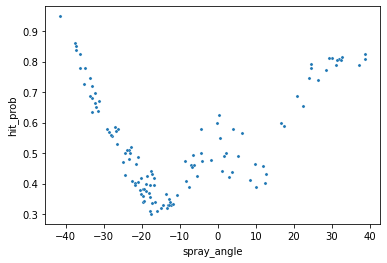

In [47]:
xba['adj_angle'] = np.where(xba['stand']=='R', xba['spray_angle'], -1*xba['spray_angle'])
xba_r=xba[xba['stand']=='R']
xba_l=xba[xba['stand']=='L']
test_data = xba_r[(xba_r['launch_angle']>=-1)&(xba_r['launch_angle']<=1)&(xba_r['launch_speed']>=89)&(xba_r['launch_speed']<=91)]
sns.scatterplot(data=test_data, x='spray_angle', y='hit_prob', s=10)

<AxesSubplot:xlabel='spray_angle', ylabel='hit_prob'>

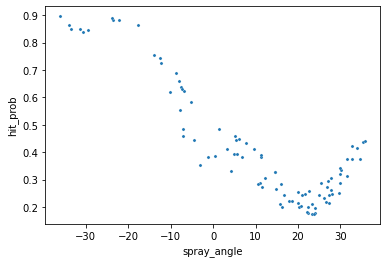

In [48]:
test_data = xba_l[(xba_l['launch_angle']>=-1)&(xba_l['launch_angle']<=1)&(xba_l['launch_speed']>=89)&(xba_l['launch_speed']<=91)]
sns.scatterplot(data=test_data, x='spray_angle', y='hit_prob', s=10)

In [50]:
xba['up_angle'] = round(xba['launch_angle'])
xba['up_speed'] = round(xba['launch_speed'])

In [64]:
test123=xba[xba['hit']==1][['game_date', 'player_name', 'batter', 'events', 'description', 'inning', 'inning_topbot', 'home_team', 'away_team', 'hit_prob']].sort_values(by='hit_prob').head(3)
test123.drop(15605)

,game_date,player_name,batter,events,description,inning,inning_topbot,home_team,away_team,hit_prob
109548,2021-04-18,"Soto, Gregory",621566,double,hit_into_play,9,Bot,OAK,DET,0.000038
1448,2021-10-02,"Ottavino, Adam",475582,double,hit_into_play,8,Bot,WSH,BOS,0.000087


In [65]:
exam1 = xba[(xba['game_date']=='2021-04-25')&(xba['home_team']=='BAL')&(xba['inning']==8)&(xba['inning_topbot']=='Top')].head(1)

exam2 = xba[(xba['game_date']=='2021-08-29')&(xba['home_team']=='PIT')&(xba['inning']==3)&(xba['inning_topbot']=='Bot')].head(1)

exam3 = xba[(xba['game_date']=='2021-05-15')&(xba['home_team']=='MIL')&(xba['inning']==7)&(xba['inning_topbot']=='Top')]

exam = pd.concat([exam1, exam2, exam3])
exam[['game_date', 'player_name', 'batter', 'events', 'description', 'inning', 'inning_topbot', 'home_team', 'away_team', 'hit_prob']].sort_values(by='hit_prob', ascending=False).head(2)

,game_date,player_name,batter,events,description,inning,inning_topbot,home_team,away_team,hit_prob
104963,2021-04-25,"Fry, Paul",605244,field_out,hit_into_play,8,Top,BAL,OAK,0.987708
24234,2021-08-29,"Kim, Kwang Hyun",621028,field_out,hit_into_play,3,Bot,PIT,STL,0.783853
